### ✅ M2_Main_Network_Analysis_and_Text_Classification.ipynb 🛣️ ⛓️

#### Functionality

This notebook performs the following:

1. **Network Analysis ⛓️**: 
    - Extracts characters and their relationships from episode data stored in a JSON file (`breaking_bad_analysisV2.json`).
        * Options for both online download from our Github and offline import
    - Builds a network graph representing characters and their interactions.
    - Calculates centrality measures like degree, betweenness, and eigenvector centrality to identify key characters.
    - Visualizes the network graph using interactive Plotly plots, highlighting character importance and communities.
    - Identifies and clusters communities (groups of closely related characters).
    - Illustrates character relationships with relation types.

2. **Text Classification 🧮**:
    - Leverages a pre-trained SetFit model to predict relationship types between pairs of characters.
    - Provides a Gradio interface to compare relationship between any two selected characters.


### Install & Import Libraries 🎛️ 

In [2]:
# Install required packages from requirements.txt
!pip install -r https://raw.githubusercontent.com/Markushenriksson13/NLP-and-Network-Analysis_Exam_Submission/refs/heads/main/requirements.txt -q

# importing the clear_output function from IPython.display module to reduce noise in outputs...
from IPython.display import clear_output
from bs4 import BeautifulSoup

# Datahandling
import requests
import os

# Network analysis
from typing import List, Optional
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import holoviews as hv
import hvplot.networkx as hvnx
from community import community_louvain
import plotly.graph_objects as go
import random
from community import community_louvain
from collections import defaultdict

# Model prediction
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report

# Gradio deployment
import gradio as gr


### Load pre-made JSON data (created from M2_LLM_Data_Fetch_and_Processing.ipynb) 📦 🧰
 * The following JSON file has been created using the Jupyter Notebook: 
     * M2_LLM_Data_Fetch_and_Processing.ipynb

#### Online Loading 🔌

In [3]:
# ONLINE DOWNLOADING JSON file from Github repository
# URL to JSON-file
url = 'https://raw.githubusercontent.com/Markushenriksson13/NLP-and-Network-Analysis_Exam_Submission/main/breaking_bad_analysisV2.json'

# Download JSON-file
response = requests.get(url)
data = response.json()  # Convert to JSON-format


#### Offline Loading of JSON 🔺

In [4]:
# OFFLINE LOADING OF JSON

#with open('breaking_bad_analysisV2.json', 'r', encoding='utf-8') as f:
#    data = json.load(f)

## Network Analysis ⛓️ 🧑‍🧑‍🧒‍🧒

In this section, we delve into the relationships between characters in the *Breaking Bad* dataset by constructing and visualizing network graphs. Here's a breakdown of our approach:

### Data Extraction and Graph Creation
We begin by extracting entities (characters, locations, etc.) and their relationships from the JSON data. This information is then used to create a network graph using the lib: `networkx`   

* Nodes in the graph represent entities
* Edges represent relationships between them

### Calculating Centrality Measures
To understand the importance of different characters within the network, we calculate various centrality measures like degree centrality, betweenness centrality, and eigenvector centrality. Which tells how connected and influential each character is within the network.

### Visualizing the Network
We use the libs  `plotly` and `matplotlib` to visualize the network graph. Node size and color are often used to represent different attributes, such as character importance or community affiliation. This allows us to visually explore the connections and structure of the network.

### Community Detection
We use the Louvain algorithm for community detection, which identifies clusters or groups of characters who are more closely connected to each other than to others in the network. This helps reveal underlying communities or factions within the *Breaking Bad* universe.

Overall, this section utilizes network analysis techniques to uncover hidden patterns and structures in the relationships between characters. By visualizing and analyzing the network, we gain a deeper understanding of the social dynamics and interactions within the show.


In [5]:
# Extract entities and relationships from each episode
entities = set()
relationships = []

for episode_data in data.values():
    for entity in episode_data["entities"]:
        entities.add((entity["name"], entity["type"]))

    for relationship in episode_data["relationships"]:
        relationships.append((relationship["source"], relationship["relation"], relationship["target"], relationship["season"]))

print(f"Loaded {len(entities)} entities and {len(relationships)} relationships.")


Loaded 275 entities and 594 relationships.


In [6]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes with their type as an attribute
for name, entity_type in entities:
    G.add_node(name, entity_type=entity_type)

# Add edges with relationship and season as attributes
for source, relation, target, season in relationships:
    G.add_edge(source, target, relation=relation, season=season)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph created with 286 nodes and 493 edges.


In [7]:
# Initialize graph
G = nx.Graph()
characters = set()
relationships = []

for episode_data in data.values():
    for entity in episode_data["entities"]:
        if entity["type"] == "Character":
            characters.add(entity["name"])

    for relationship in episode_data["relationships"]:
        relationships.append((relationship["source"], relationship["relation"], relationship["target"], relationship["season"]))

# Add nodes and edges to the graph
for char in characters:
    G.add_node(char, type="Character")

for source, relation, target, season in relationships:
    if source in G and target in G:
        G.add_edge(source, target, relation=relation, season=season)

# Calculate various centrality measures for node significance
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
closeness_centrality = nx.closeness_centrality(G)

# Create a composite importance score
node_importance = {
    node: (degree_centrality[node] + betweenness_centrality[node] + eigenvector_centrality[node]) / 3
    for node in G.nodes
}

# Scale node sizes based on importance
node_size = [20 + 100 * node_importance[node] for node in G.nodes]

# Use a more spread out layout with stronger repulsion
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Extract edge positions
edge_x, edge_y = [], []
edge_texts = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_texts.append(f"{edge[0]} - {edge[2]['relation']} - {edge[1]}<br>Season: {edge[2]['season']}")

# Extract node positions
node_x, node_y, node_text = [], [], []
for node in G.nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(
        f"Character: {node}<br>"
        f"Degree Centrality: {degree_centrality[node]:.3f}<br>"
        f"Betweenness Centrality: {betweenness_centrality[node]:.3f}<br>"
        f"Eigenvector Centrality: {eigenvector_centrality[node]:.3f}"
    )

# Create Plotly figure
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.8, color='rgba(169,169,169,0.5)'),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes],
    textposition="top center",
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=[node_importance[node] for node in G.nodes],
        colorscale='Viridis',
        line=dict(width=1, color='white'),
        showscale=True,
        colorbar=dict(title="Character Importance")
    )
))

# Customize layout
fig.update_layout(
    title={
        'text': "Breaking Bad Character Network",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1200,
    height=1000,
    showlegend=False,
    hovermode='closest',
    plot_bgcolor='rgb(250,250,250)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Add zoom capabilities and better interaction
fig.update_layout(
    dragmode='pan',
    clickmode='event+select'
)

fig.show()

In [8]:
# Calculate network structure indicators
network_density = nx.density(G)
average_clustering = nx.average_clustering(G)
# Check if the graph is connected before calculating average shortest path and diameter
if nx.is_connected(G):
    average_shortest_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
else:
    average_shortest_path = "Graph is disconnected"
    diameter = "Graph is disconnected"  # Or any other appropriate value

number_of_nodes = G.number_of_nodes()
number_of_edges = G.number_of_edges()

# Print network structure metrics
print("\nNetwork Structure Indicators:")
print(f"Network Density: {network_density:.3f}")
print(f"Average Clustering Coefficient: {average_clustering:.3f}")
print(f"Number of Nodes: {number_of_nodes}")
print(f"Number of Edges: {number_of_edges}")


Network Structure Indicators:
Network Density: 0.021
Average Clustering Coefficient: 0.213
Number of Nodes: 101
Number of Edges: 104


#### Community clustering 🔴 🟡 🟢 🔵
 * ℹ️ Tip!: Click the Zoom function ➕ 🔎 to zoom in to review each cluster in more detail.
 * ℹ️ Tip 2!: Click the Pan function to drag around.

In [9]:
G = nx.Graph()
relation_types = set()

for episode_data in data.values():
    for rel in episode_data.get('relationships', []):
        G.add_edge(rel['source'], rel['target'], relation=rel['relation'])
        relation_types.add(rel['relation'])

# Apply community detection for clustering
partition = community_louvain.best_partition(G)
unique_communities = set(partition.values())
community_colors = {community: f'#{random.randint(0, 0xFFFFFF):06x}' for community in unique_communities}

# Separate nodes by community for modular layout
# Create a dictionary to hold positions of each node by community
community_positions = {}
for community in unique_communities:
    # Subgraph for each community
    subgraph = G.subgraph([node for node in G.nodes() if partition[node] == community])
    # Apply spring layout to each community separately
    pos = nx.spring_layout(subgraph, k=0.4, iterations=50)
    community_positions.update(pos)

# Spread communities apart to avoid overlap
offset = 3.0  # Adjust to control spacing between communities
for i, community in enumerate(unique_communities):
    for node in [n for n in G.nodes() if partition[n] == community]:
        community_positions[node][0] += (i % 5) * offset
        community_positions[node][1] += (i // 5) * offset

# Create color map for relation types
relation_colors = {rel: f'#{random.randint(0, 0xFFFFFF):06x}' for rel in relation_types}

# Create edge traces with color based on relation type
edge_traces = [
    go.Scatter(
        x=[community_positions[e[0]][0], community_positions[e[1]][0], None],
        y=[community_positions[e[0]][1], community_positions[e[1]][1], None],
        line=dict(width=0.5, color=relation_colors[e[2]['relation']]),
        hoverinfo='text',
        text=e[2]['relation'],
        mode='lines'
    ) for e in G.edges(data=True)
]

# Calculate node sizes based on degree
node_sizes = [10 + 5 * G.degree(node) for node in G.nodes()]

# Create node trace with community-based coloring
node_trace = go.Scatter(
    x=[community_positions[node][0] for node in G.nodes()],
    y=[community_positions[node][1] for node in G.nodes()],
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        size=node_sizes,
        color=[community_colors[partition[node]] for node in G.nodes()],
        line=dict(width=2)
    ),
    textfont=dict(size=8)
)

# Create figure
fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title="Breaking Bad Network with Clustered Community Colors",
    showlegend=False,
    width=1200,
    height=1000,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    annotations=[dict(
        text="Breaking Bad Network with Clustered Community Colors",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002
    )],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


#### Breaking Bad Network based on type of entity: 🗂️

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_4682/3220723636.py:43: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



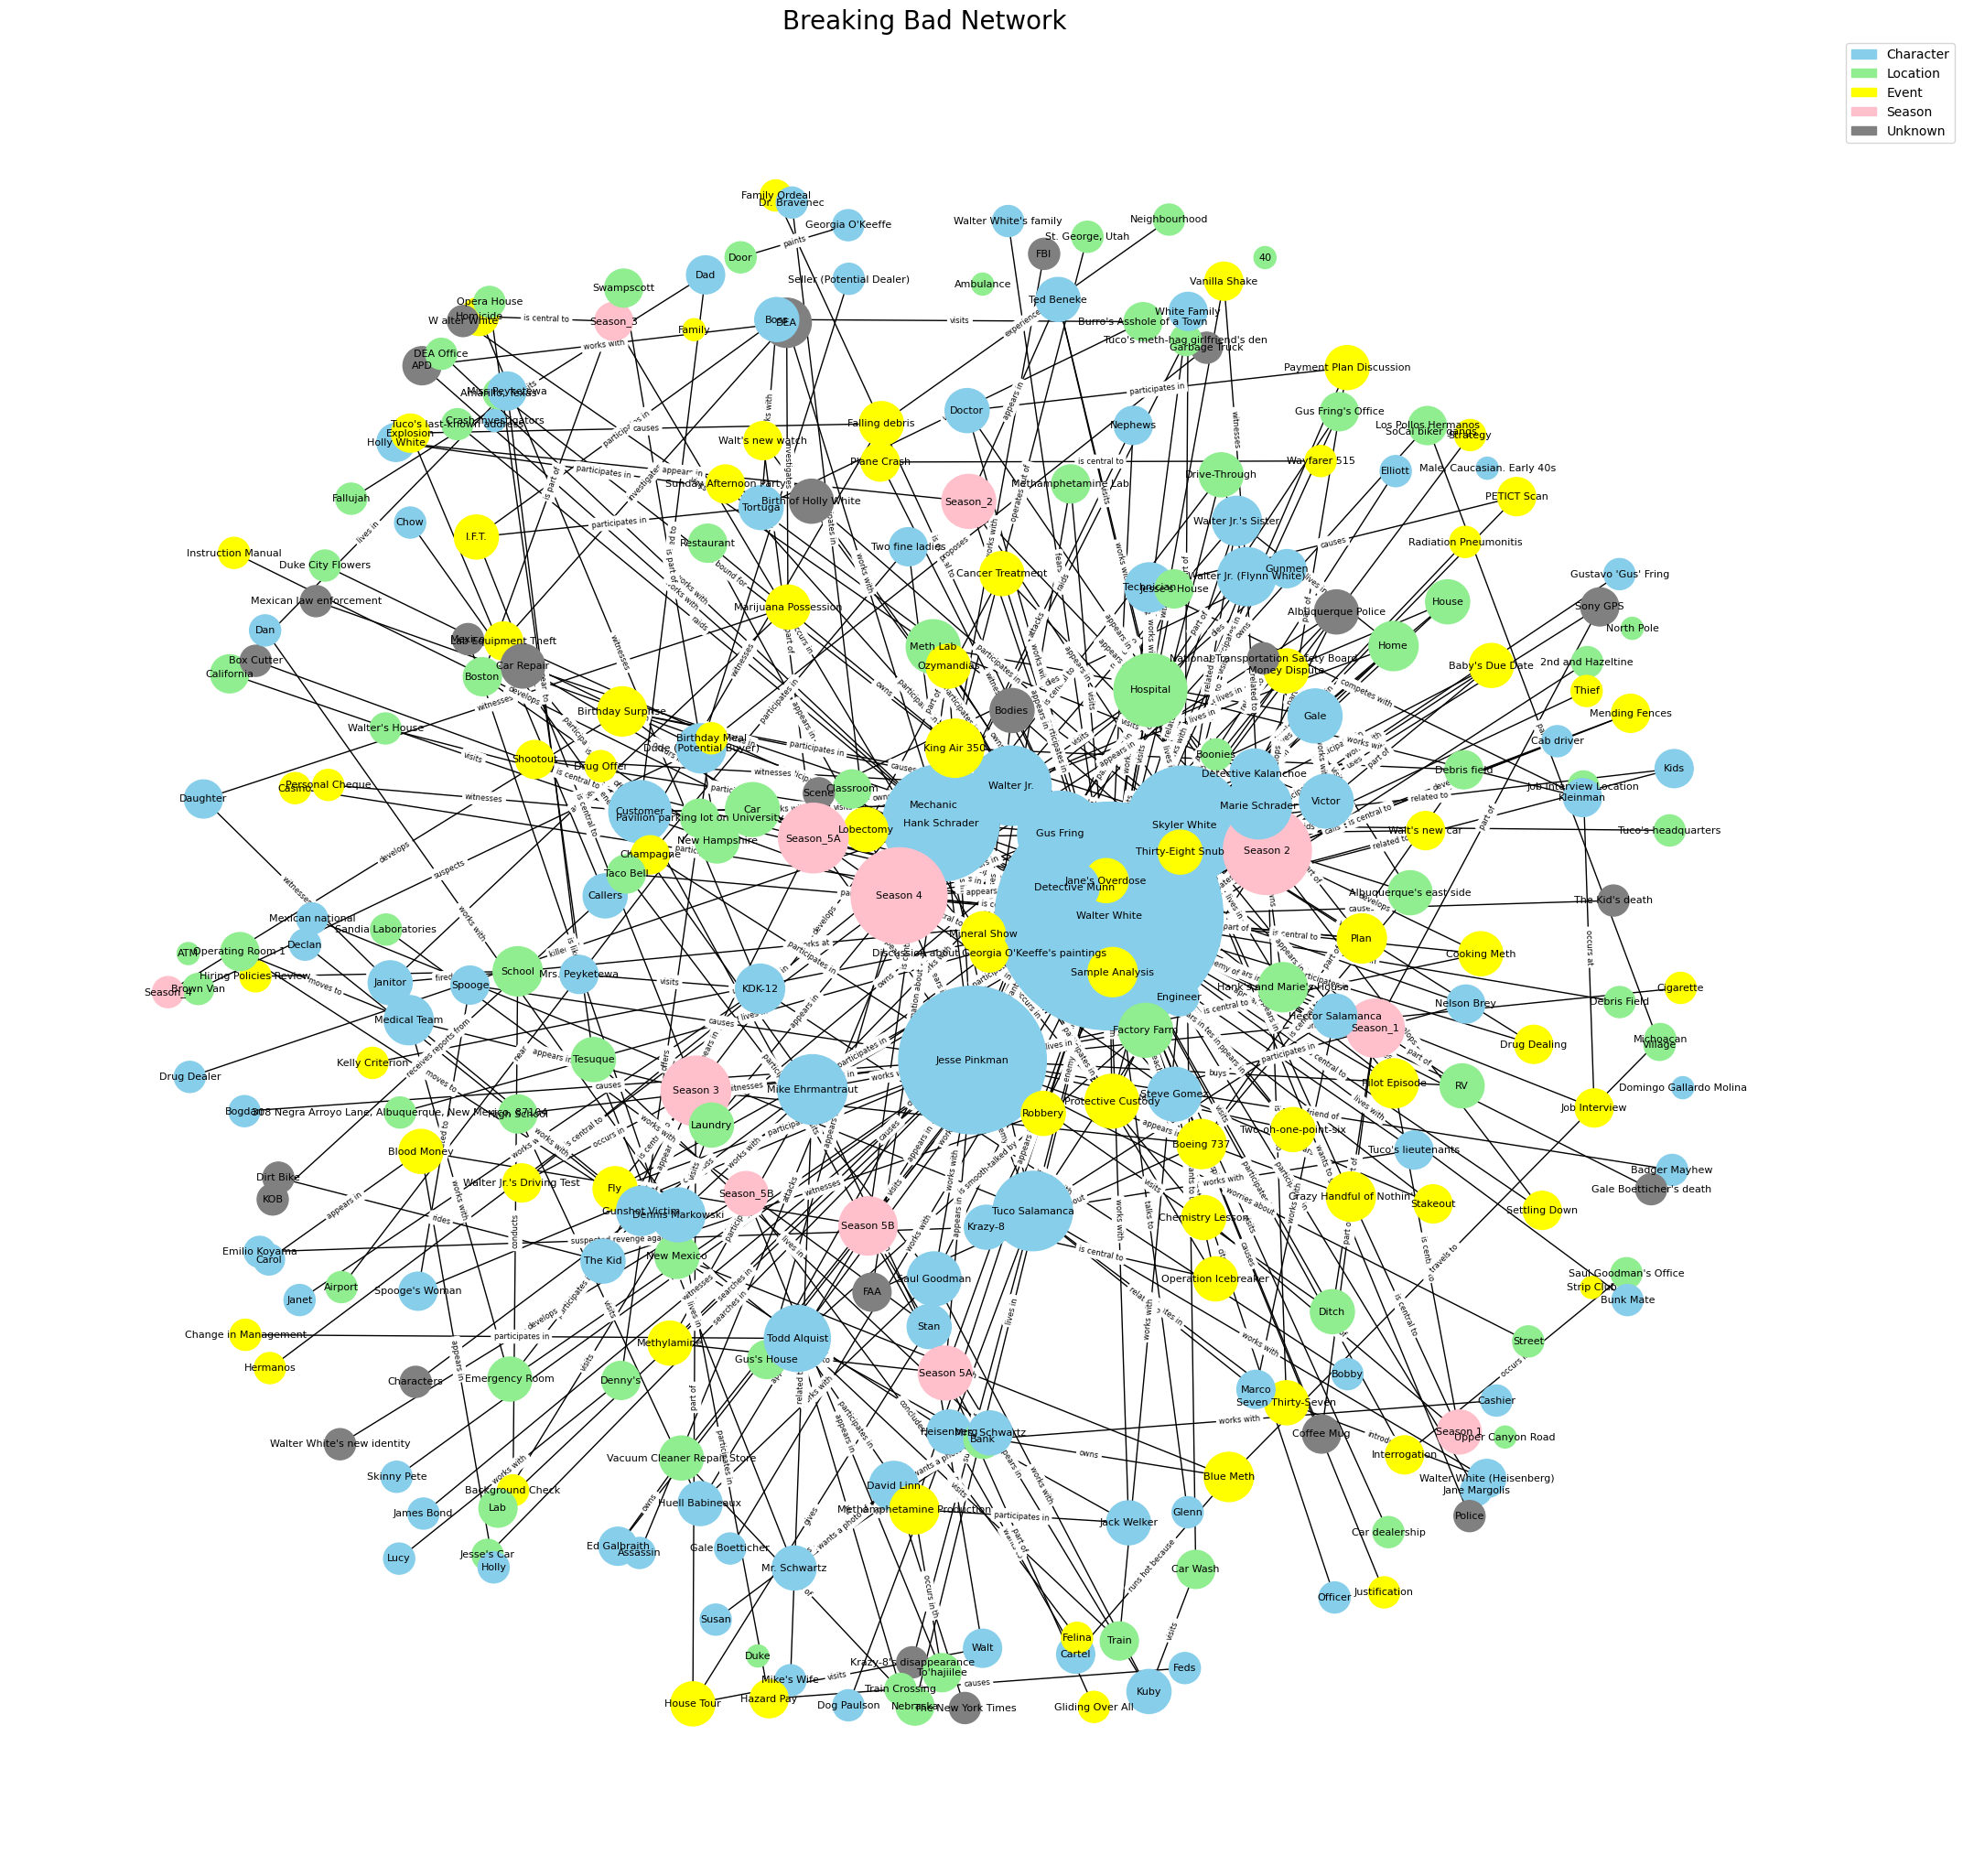

Network Visualisation has been saved as 'breaking_bad_network.png'


In [10]:
# create a graph
G = nx.Graph()

# add nodes and edges
for episode, content in data.items():
    for entity in content['entities']:
        G.add_node(entity['name'], type=entity['type'])
    
    for relation in content['relationships']:
        source = relation['source']
        target = relation['target']
        if source not in G.nodes():
            G.add_node(source, type='Unknown')
        if target not in G.nodes():
            G.add_node(target, type='Unknown')
        G.add_edge(source, target, 
                   relation=relation['relation'], 
                   season=relation['season'])

# define colors for different node types
color_map = {'Character': 'skyblue', 'Location': 'lightgreen', 
             'Event': 'yellow', 'Season': 'pink', 'Unknown': 'gray'}

# get node colors and sizes
node_colors = [color_map.get(G.nodes[node].get('type', 'Unknown'), 'gray') for node in G.nodes()]
node_sizes = [300 * (1 + G.degree(node)) for node in G.nodes()]

# draw the graph
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=node_sizes, font_size=8)

# add edge labels
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# add legend
legend_elements = [mpatches.Patch(color=color, label=type) for type, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Breaking Bad Network", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("breaking_bad_network.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

print("Network Visualisation has been saved as 'breaking_bad_network.png'")

## Text Classification 📠 

In this section, we focus on classifying relationships between characters in the *Breaking Bad* dataset, using a pre-trained SetFit model. We’ll walk through the following steps to make our model predict character relationships interactively:

### 🌟  1. Loading the Pre-trained SetFit Model
We start by loading the SetFit model using the `SetFitModel.from_pretrained` function. This points to the saved location of a model previously trained on a dataset containing descriptions of character relationships.

### 🎭  2. Extracting Character Names
Next, we read the JSON data to extract all unique character names from the `entities` section. These names help us create dropdown options in the Gradio Interface for the user to select specific characters.

### 🔍  3. Comparing Relationships
We define the `compare_relationships` function, which takes two character names as input and uses the loaded SetFit model to predict the relationship between them. It predicts relationships in both directions (e.g., “Walter White - Jesse Pinkman” and “Jesse Pinkman - Bobby). 

### 🖥️  4.  Gradio Interface
We have build a simple user interface using the Gradio library. This UI includes two dropdown menus for character selection and a textbox that displays the results of the relationship classification.


In [11]:
# FOR GOOGLE COLAB: 
# Load pre_trained model

#!git clone https://github.com/Markushenriksson13/NLP-and-Network-Analysis_Exam_Submission.git
#model = SetFitModel.from_pretrained('NLP-and-Network-Analysis_Exam_Submission/saved_model')


In [12]:
# OFFLINE:
# Load pre_trained model
model = SetFitModel.from_pretrained('saved_model')

You try to use a model that was created with version 3.2.1, however, your version is 3.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator LogisticRegression from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [13]:
# find all unique characters from "entities"
characters = set()
for episode, episode_data in data.items():
    for entity in episode_data["entities"]:
        if entity["type"] == "Character":
            characters.add(entity["name"])

# convert to a sorted list for consistent display
characters = sorted(characters)

# function to compare the relationship between two selected characters
def compare_relationships(model, char1, char2):
    result = f"Comparing relationship between {char1} and {char2}:\n"
    
    # test relationship both ways
    forward = model.predict([f"{char1} - {char2}"])[0]
    backward = model.predict([f"{char2} - {char1}"])[0]
    
    # add the result for each pair
    result += f"\n{char1} <-> {char2}:\n"
    result += f"  {char1} -> {char2}: {forward}\n"
    result += f"  {char2} -> {char1}: {backward}\n"
    
    return result

# gradio interface function
def gradio_interface(char1, char2):
    return compare_relationships(model, char1, char2)

# create dropdown menus with character options
char1_dropdown = gr.Dropdown(choices=characters, label="Select first character (char1)")
char2_dropdown = gr.Dropdown(choices=characters, label="Select second character (char2)")
output = gr.Textbox(label="Results")

# initialize and start the gradio app
gr.Interface(fn=gradio_interface, inputs=[char1_dropdown, char2_dropdown], outputs=output, title="Relationship Comparison").launch()


/opt/anaconda3/lib/python3.12/site-packages/gradio/routes.py:1215: DeprecationWarning:


        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        

/opt/anaconda3/lib/python3.12/site-packages/fastapi/applications.py:4495: DeprecationWarning:


        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        



Running on local URL:  http://127.0.0.1:7860


/opt/anaconda3/lib/python3.12/site-packages/gradio/analytics.py:106: UserWarning:

IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------




To create a public link, set `share=True` in `launch()`.


/opt/anaconda3/lib/python3.12/site-packages/starlette/templating.py:161: DeprecationWarning:

The `name` is not the first parameter anymore. The first parameter should be the `Request` instance.
Replace `TemplateResponse(name, {"request": request})` by `TemplateResponse(request, name)`.

